## imports

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm
import os

In [4]:
import meshpy.triangle as tri
from skimage import io
from skimage.measure import find_contours

In [5]:
from video_processing import get_first_frame

## our object

In [6]:
# 
frame_0 = get_first_frame(framepath='images/frame_0.png')

In [7]:
# Загрузка изображения силуэта объекта
frame_0_mask = io.imread(pjoin('images','frame_0_mask.png'))

# Преобразование изображения в бинарное
binary_image = frame_0_mask[:, :, 0] > 0

### simple mesh

In [8]:
h, w = frame_0_mask.shape[:2]

In [9]:
x_mash_step, y_mash_step = 40, 40

In [10]:
y_mash = np.arange(0, h, y_mash_step)
x_mash = np.arange(0, w, x_mash_step)

In [11]:
_s = np.load(pjoin('actual pos','all_pos_vals.npy'))

In [12]:
_s[0] # (x, y)

array([[9.93198395e-01, 9.60201454e+00],
       [1.01012421e+00, 2.59780769e+01],
       [1.01922035e+00, 4.20226517e+01],
       ...,
       [2.15700000e+03, 7.61000000e+02],
       [2.15700000e+03, 7.77000000e+02],
       [2.15700000e+03, 7.93000000e+02]])

In [13]:
xy_mesh = np.meshgrid(x_mash, y_mash)

In [14]:
nodes = np.dstack([xy_mesh[0].T, xy_mesh[1].T]).reshape(-1, 2)

In [15]:
binary_image.shape

(1080, 1920)

In [16]:
binary_image[nodes[0][0], nodes[0][1]]

False

In [17]:
nodes_for_ilsur = list()

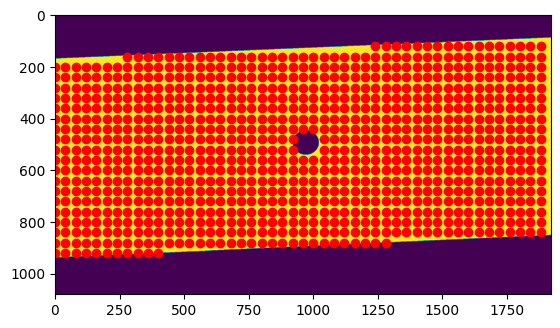

In [18]:
for node in nodes:
    if binary_image[node[1], node[0]]:
        nodes_for_ilsur.append((node[0], node[1]))
        plt.plot(node[0], node[1], 'ro')
plt.imshow(binary_image)
plt.show()

In [19]:
nodes_for_ilsur = np.array(nodes_for_ilsur)

In [20]:
# nodes_for_ilsur_old = nodes_for_ilsur.reshape(-1,1,2)

In [21]:
# np.save('nodes_for_ilsur.npy', nodes_for_ilsur)

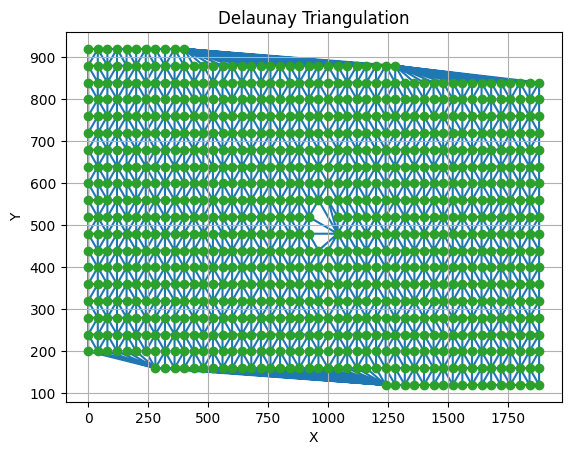

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Generate some random points as an example

points = nodes_for_ilsur.reshape(-1, 2)

# Perform Delaunay triangulation
tri = Delaunay(points)

# Plot the triangulation
plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
plt.plot(points[:, 0], points[:, 1], 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')
plt.grid(True)
plt.show()

### Filter triangles out of border

In [24]:
conn_table = tri.simplices.copy()

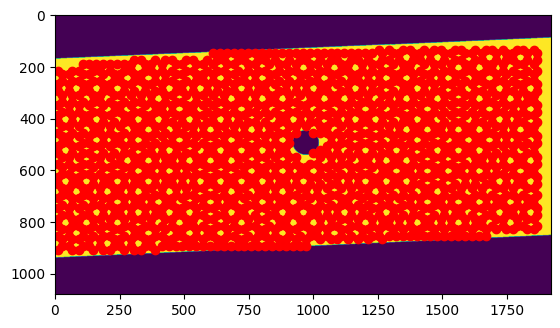

In [26]:
conn_table_copy = list()
k = 0
for tr in conn_table:
    coords = nodes_for_ilsur[tr]*1.
    center = coords.mean(axis=0)
    if binary_image[int(center[1]), int(center[0])]:
        conn_table_copy.append(tr)
        plt.plot(center[0], center[1], 'ro')
plt.imshow(binary_image)
plt.show()

In [27]:
conn_table = np.array(conn_table_copy)

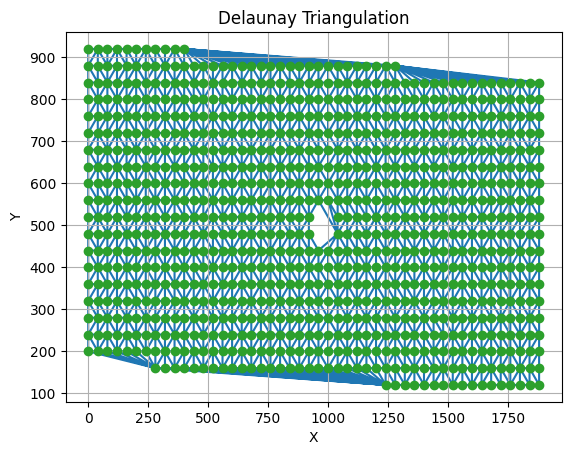

In [28]:
plt.triplot(points[:, 0], points[:, 1], conn_table)
plt.plot(points[:, 0], points[:, 1], 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')
plt.grid(True)
plt.show()

### Filter stretched triangles with long edges

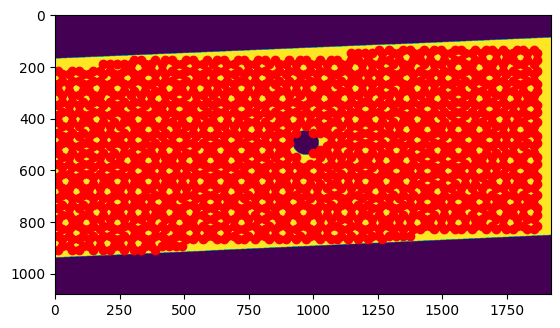

In [63]:
conn_table_copy = list()
k = 0
for tr in conn_table:    
    coords = nodes_for_ilsur[tr]*1.
    edge_lens = np.linalg.norm(coords - np.roll(coords, shift=1, axis=0), axis=-1)
    max_ratio = max(edge_lens / min(edge_lens))
    
    if max_ratio < 5:
        conn_table_copy.append(tr)
        center = coords.mean(axis=0)
        plt.plot(center[0], center[1], 'ro')
plt.imshow(binary_image)
plt.show()

In [64]:
conn_table = np.array(conn_table_copy)

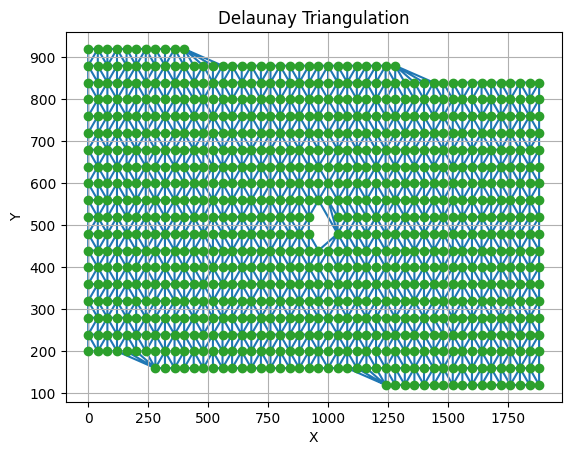

In [65]:
plt.triplot(points[:, 0], points[:, 1], conn_table)
plt.plot(points[:, 0], points[:, 1], 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')
plt.grid(True)
plt.show()

### Saving conn and coord

In [66]:
_copy = nodes_for_ilsur.copy()
nodes_for_ilsur = np.zeros((nodes_for_ilsur.shape[0], 3))
nodes_for_ilsur[:,0:2] = _copy

In [69]:
mesh_name = f'{len(nodes_for_ilsur)}_{len(conn_table)}'
data_folder = pjoin('visualisation data', mesh_name)

In [70]:
idx = 0
while os.path.exists(f'{data_folder}_{idx}'):
    idx += 1
os.makedirs(f'{data_folder}_{idx}')

In [71]:
np.save(pjoin(f'{data_folder}_{idx}', f'coord_table.npy'), nodes_for_ilsur)
np.save(pjoin(f'{data_folder}_{idx}', f'conn_table.npy'), conn_table)

### triangular

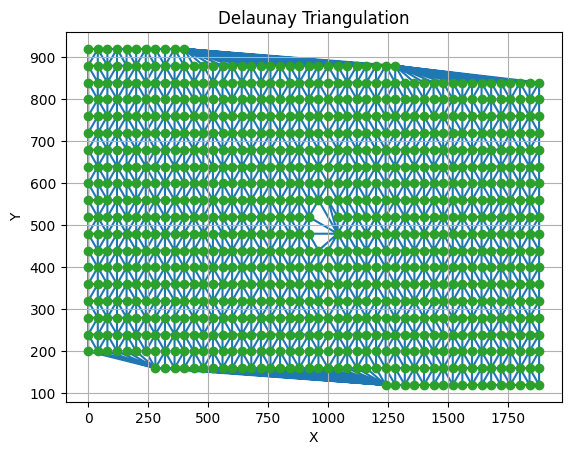

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Generate some random points as an example

points = nodes_for_ilsur.reshape(-1, 2)

# Perform Delaunay triangulation
tri = Delaunay(points)

# Plot the triangulation
plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
plt.plot(points[:, 0], points[:, 1], 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')
plt.grid(True)
plt.show()

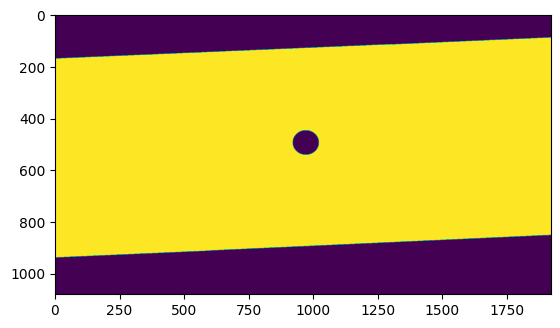

In [79]:
plt.imshow(binary_image)
plt.show()

In [80]:
pad_size = 10

[]

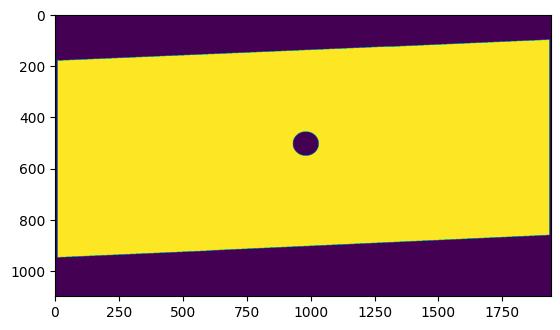

In [81]:
plt.imshow(np.pad(binary_image,pad_size))
plt.plot()

In [82]:
# Нахождение контура объекта
contours = find_contours(np.pad(binary_image,pad_size), 0.5)

In [83]:
frame_0 = cv2.imread(pjoin('images','frame_0.png'))

In [84]:
np.pad(frame_0, ((pad_size, pad_size), (pad_size, pad_size), (0,0))).shape

(1100, 1940, 3)

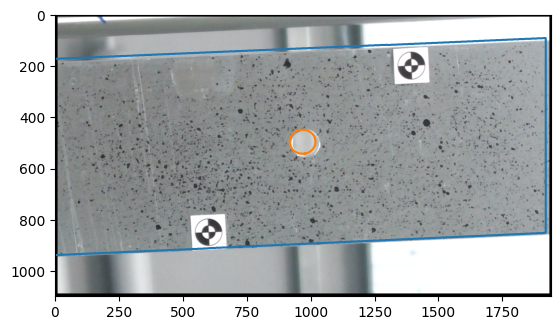

In [109]:
plt.imshow(np.pad(frame_0, ((pad_size, pad_size), (pad_size, pad_size), (0,0))))
for c in contours:
    plt.plot(c[::4,1],c[::4,0])
plt.show()

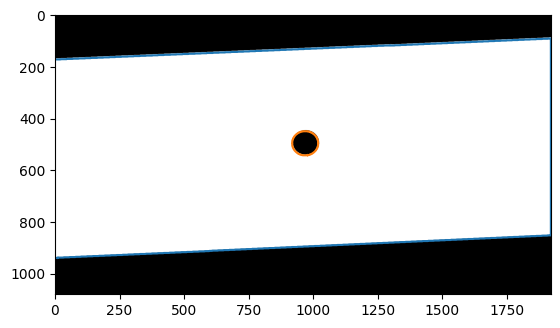

In [86]:
plt.imshow(image)
for c in contours:
    plt.plot(c[:,1]-pad_size,c[:,0]-pad_size)
plt.show()

In [87]:
moved_contours = contours.copy()

In [88]:
for i, c in enumerate(moved_contours):
    contours[i] = c - pad_size

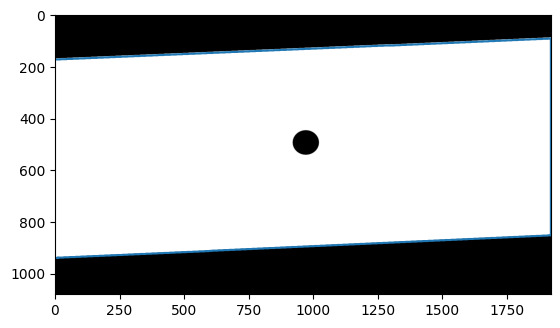

In [89]:
plt.imshow(image)
# for c in contours:
plt.plot(contours[0][:,1],contours[0][:,0])
plt.show()

In [90]:
px_diam = 106.
mm_diam = 10.

In [91]:
mm_contours = contours.copy()

In [92]:
for i, c in enumerate(contours):
    mm_contours[i] = c / 10.6

In [93]:
import pandas as pd

In [96]:
mm_contours[0][:,::-1]

array([[ 0.94339623, 88.53773585],
       [ 0.8490566 , 88.53773585],
       [ 0.75471698, 88.53773585],
       ...,
       [ 1.03773585, 88.44339623],
       [ 0.99056604, 88.49056604],
       [ 0.94339623, 88.53773585]])

In [97]:
pd.DataFrame(mm_contours[0][:,::-1]).to_csv('out_contour_rot.txt', index=False, header=False)

In [98]:
pd.DataFrame(mm_contours[1][:,::-1]).to_csv('in_contour_rot.txt', index=False, header=False)

## load dat files

In [10]:
import re

In [1]:
from os.path import join as pjoin
from dat_reader import read_connectivity_table, read_coordinates_table

In [2]:
filename = pjoin('dat files', 'squre_mesh.dat')

In [3]:
conn_table = read_connectivity_table(filename)
print(conn_table)

[[   0   37   38  286   36]
 [   1   38   39  287  286]
 [   2   39   40  288  287]
 ...
 [3881 3337 3518 3508 3348]
 [3882 2749 3008 2974 2922]
 [3883 3008 2749 2961 3452]]


In [5]:
# Example usage:
node_num, conn_table = read_coordinates_table(filename)
print(node_num)
print(conn_table)

4027
[[0, 1898.9118241758242, 852.4485054945053, 0.0], [1, 1920.0, 851.4979999999998, 0.0], [2, 1920.0088333333333, 830.3318611111097, 0.0], [3, 1920.0176666666666, 809.1657222222213, 0.0], [4, 1920.0265, 787.9995833333323, 0.0], [5, 1920.0353333333333, 766.8334444444434, 0.0], [6, 1920.0441666666666, 745.6673055555549, 0.0], [7, 1920.053, 724.5011666666661, 0.0], [8, 1920.0618333333334, 703.3350277777772, 0.0], [9, 1920.0706666666667, 682.1688888888882, 0.0], [10, 1920.0795, 661.0027499999995, 0.0], [11, 1920.0883333333334, 639.8366111111106, 0.0], [12, 1920.0971666666667, 618.6704722222217, 0.0], [13, 1920.106, 597.504333333333, 0.0], [14, 1920.1148333333333, 576.3381944444441, 0.0], [15, 1920.1236666666666, 555.1720555555553, 0.0], [16, 1920.1325, 534.0059166666664, 0.0], [17, 1920.1413333333333, 512.8397777777775, 0.0], [18, 1920.1501666666666, 491.6736388888885, 0.0], [19, 1920.159, 470.50749999999977, 0.0], [20, 1920.1678333333334, 449.3413611111109, 0.0], [21, 1920.1766666666667